Globally averaged temperature:

$$
\frac{dT}{dt} = R_i(T) -  R_0(T, C)
$$

Accumulated anthropogenic carbon, $S_a$
$$
\frac{d S_a}{dt} = C_a
$$

Atmospheric carbon concentration:

$$
\frac{dC}{dt} = v + C_a - W_a A_v C g^{vege}(T) + \frac{c_0}{\tau_c} \kappa_P (1 - f(T)) + \frac{c_0}{\tau_c} \kappa_B(S_a) (1 - f(T)) - \frac{\lambda}{\tau_c} C(1 - f(T))
$$

Temperature anomaly:
$$
\tilde{T} = T - T_{preindustrial}
$$



$$
\begin{align}
\delta \phi(\tilde{T}, C, S_a) =& \max_{C_a} \eta \delta \log C_a  \\
& + \frac{d \phi (\tilde{T}, C, S_a)}{d\tilde{T}} \left( R_i(T) - R_0(T, C) \right)\\
& + \frac{d\phi(\tilde{T}, C, S_a)}{d C} \left( v + C_a - W_a A_v C g^{vege}(T) + \frac{c_0}{\tau_c} \kappa_P (1 - f(T)) + \frac{c_0}{\tau_c} \kappa_B(S_a) (1 - f(T)) - \frac{\lambda}{\tau_c} C(1 - f(T))\right)\\
& + \frac{d \phi (\tilde{T}, C, S_a)}{d S_a} C_a \\
& + (\eta - 1) (\gamma_1 + \gamma_2 \tilde{T}) (R_i(T) - R_0(T, C))
\end{align}
$$

$$
C_a^{*} = - \frac{\delta \eta}{\frac{d \phi (\tilde{T}, C, S_a)}{d C} + \frac{d \phi (\tilde{T}, C, S_a)}{d S_a} }
$$

In [1]:
import sys
sys.path.append("../src/")
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq
from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import SymLogNorm
import matplotlib.mlab
import scipy.io as sio
import pandas as pd
import scipy.optimize as optim
from scipy.optimize import curve_fit
from scipy import interpolate
from scipy import fft, arange, signal
from scipy.interpolate import RegularGridInterpolator
import SolveLinSys
from supportfunctions import finiteDiff
rcParams["figure.figsize"] = (8,5)
                                                                                
def PDESolver(stateSpace, A, B1, B2, B3, C1, C2, C3, D, v0, 
              ε = 1, tol = -10):                                              
                                                                                 

    A = A.reshape(-1,1,order = 'F')                                         
    B = np.hstack([B1.reshape(-1,1,order = 'F'),B2.reshape(-1,1,order = 'F'),B3.reshape(-1,1,order='F')])
    C = np.hstack([C1.reshape(-1,1,order = 'F'),C2.reshape(-1,1,order = 'F'),C3.reshape(-1,1,order='F')])
    D = D.reshape(-1,1,order = 'F')                                         
    v0 = v0.reshape(-1,1,order = 'F')                                       
    out = SolveLinSys.solveFT(stateSpace, A, B, C, D, v0, ε, tol)           

    return out                                                            

In [2]:
# Pre-industrial: 282.87K

sa = 1
# Incoming radiation
Q0 = 342.5
## land fraction and albedo
#Fraction of land on the planet
p = 0.3

## outgoing radiation linearized
kappa  = 1.74
Tkappa = - 119.15
# Greenhouse effect parameter
B = 5.35 # a in the notes, CO2 radiative forcing

## Volcanism emissions
Volcan = 0.05964

Ts =   9.72
Cs = 587.40 # Average carbon with no Ca

alphaland = 0.28
bP = 0.05
bB = 0.08
cod = 3.035 # λ in the notes, Oceanic pump modulation parameter
cearth = 0.107 # heat capacity
tauc = 20
coc0 =  745.5 # initial oceanic carbon stock
## Ocean albedo parameters, in celsius
Talphaocean_low  = - 54.15
Talphaocean_high = 25.85
alphaocean_min   = 0.255
alphaocean_max   = 0.84


Cbio_low  = 106.5 # Gt
Cbio_high = 1491 # Gt

T0 = 24.85
C0 = 596.5 # reference CO2 level, in Gt

## CO2 uptake by vegetation
wa       = 0.03195 # Gt/yr
vegcover = 0.4 # Av in notes

Thigh = 41.85
Tlow  =  8.85
Topt1 = 21.85
Topt2 = 36.85
acc   = 5


# Ocean albedo
def alphaocean(T):
    """T, matrix, (nT, nC, nF)"""
    temp = np.zeros(T.shape)
    temp[ T< Talphaocean_low ] = alphaocean_max
    temp[ (T>= Talphaocean_low)&(T< Talphaocean_high)] = alphaocean_max + (alphaocean_min - alphaocean_max) / (Talphaocean_high - Talphaocean_low) * (T[(T>= Talphaocean_low)&(T< Talphaocean_high)] - Talphaocean_low)
    temp[T>= Talphaocean_high] = alphaocean_min

    return temp
    
#Fraction of ocean covered by ice
def fracseaice(T):
    
    temp = np.zeros(T.shape)
    temp[ T< Talphaocean_low ] = 1
    temp[ (T>= Talphaocean_low)&(T< Talphaocean_high)] = 1 - 1 / (Talphaocean_high - Talphaocean_low) * (T[(T>= Talphaocean_low)&(T< Talphaocean_high)] - Talphaocean_low)
    temp[T>= Talphaocean_high] = 0

    return temp
    


def biopump(F):
    """F, accumulated anthrpogenic emission"""
    temp = np.zeros(F.shape)
    
    temp[F < Cbio_low] = 1
    temp[(F >= Cbio_low)&(F < Cbio_high)] = 1 - 1/(Cbio_high - Cbio_low) * (F[(F >= Cbio_low)&(F < Cbio_high)] - Cbio_low)
    temp[F >= Cbio_high] = 0
    return temp


def veggrowth(T):
    
    temp = np.zeros(T.shape)
    
    temp[T < Tlow] = 0
    temp[(T >= Tlow)&(T < Topt1)] = acc / (Topt1 - Tlow) * (T[(T >= Tlow)&(T < Topt1)] - Tlow)
    temp[(T >= Topt1)&(T < Topt2)] = acc
    temp[(T >= Topt2)&(T < Thigh)] = acc / (Topt2 - Thigh) * (T[(T >= Topt2)&(T < Thigh)] - Thigh)
    temp[T > Thigh] = 0
    
    return temp


#Incoming radiation modified by albedo
def Ri(T):
    return 1/cearth * (Q0 * (1 - p * alphaland - (1 - p) * alphaocean(T)))

# Outgoing radiation modified by greenhouse effect
def Ro(T, C):
    return 1/cearth * (kappa * (T - Tkappa) -  B * np.log(C / C0))

#Solubility of atmospheric carbon into the oceans
# carbon pumps
def kappaP(T):
    return np.exp(-bP * (T - T0))

def oceanatmphysflux(T):
    return 1 / tauc * (coc0 * (np.exp(-bP * (T - T0))))

def oceanbioflux(T, F, sa):
    
    if sa == 1:
        
        return 1/tauc * (coc0 * (np.exp(bB * biopump(F) * (T - T0))))
    
    elif sa == 0:
        
        return 1/tauc * (coc0 * (np.exp(bB * (T - T0))))
    
    else:
        return ValueError("Wrong input value: 0 or 1.")

def oceanatmcorrflux(C):
    return 1 / tauc * (- cod * C)

In [3]:
# Economic paramaters
gamma_1 = 1.7675 / 10000.
gamma_2 = 2 * 0.0022
delta   = 0.01
eta     = 0.032

# State variable
# Temperature anomaly, in celsius
T_min  = 0. 
T_max  = 20. # 
hT     = 0.2
T_grid = np.arange(T_min, T_max + hT, hT)

# atmospheric carbon concentration, in gigaton
C_min  = 532.5
C_max  = 1065
hC     = 10
C_grid = np.arange(C_min, C_max + hC, hC)

# F, Sa in the notes, accumulative anthropogenic carbon, in gigaton
F_min = 10 # 10. avaoid 
F_max = 5325. # 2500 x2.13 gm # # on hold -> 4000 / 2.13 ppm
hF = 50.
F_grid = np.arange(F_min, F_max + hF, hF)

# meshgrid
(T_mat, C_mat, F_mat) = np.meshgrid(T_grid, C_grid, F_grid, indexing="ij")
stateSpace = np.hstack([
    T_mat.reshape(-1, 1, order="F"),
    C_mat.reshape(-1, 1, order="F"),
    F_mat.reshape(-1, 1, order="F")
])

T_mat.shape

(101, 55, 108)

In [4]:
To = 9.72 # Mean with no anthropogenic carbon emissions, in Cᵒ

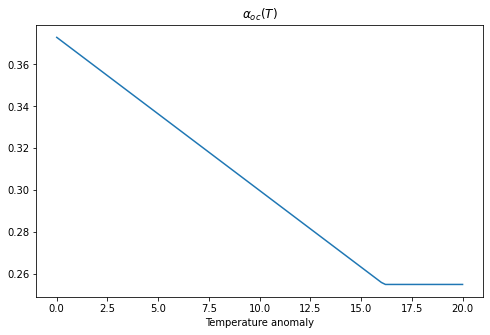

(0.255, 0.37295062500000004)

In [5]:
α_ocean = alphaocean(T_grid + To)
plt.plot(T_grid, α_ocean)
plt.xlabel("Temperature anomaly")
plt.title("$α_{oc}(T)$")
plt.show()
α_ocean.min(), α_ocean.max()

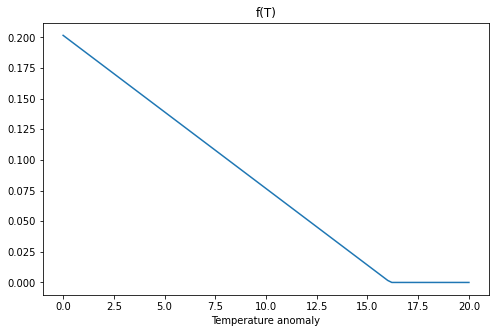

(0.0, 0.20162499999999994)

In [6]:
frac_sea_ice = fracseaice(T_grid + To)
plt.plot(T_grid, frac_sea_ice)
plt.xlabel("Temperature anomaly")
plt.title("f(T)")
plt.show()
frac_sea_ice.min(), frac_sea_ice.max()

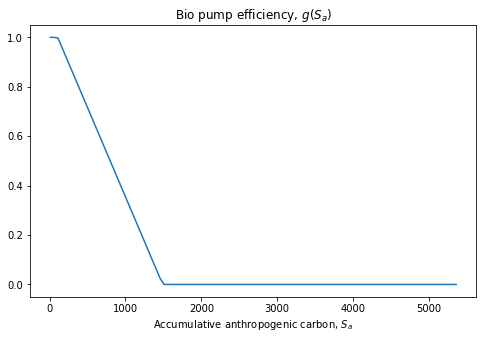

In [7]:
bio_pump_efficiency = biopump(F_grid)
plt.plot(F_grid, bio_pump_efficiency)
plt.xlabel("Accumulative anthropogenic carbon, $S_a$")
plt.title("Bio pump efficiency, $g(S_a)$")
plt.show()

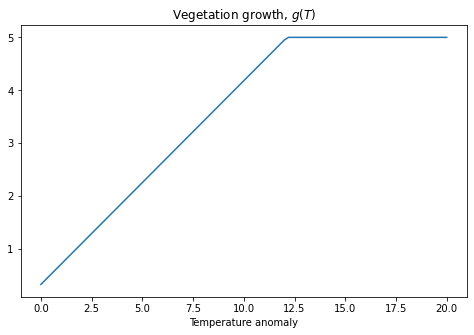

(0.334615384615385, 5.0)

In [8]:
vege_growth = veggrowth(To + T_grid)


plt.plot(T_grid, vege_growth)
plt.xlabel("Temperature anomaly")
plt.title("Vegetation growth, $g(T)$")
plt.show()

vege_growth.min(), vege_growth.max()

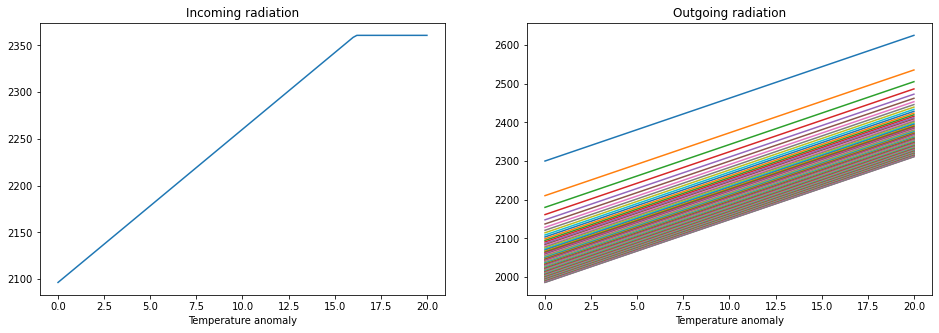

In [9]:
plt.subplots(1,2, figsize=(16, 5))
plt.subplot(121)

plt.title("Incoming radiation")
ri = Ri(To + T_grid)
ro = Ro(To + T_mat[:, 0, :], F_mat[:,0, :])
plt.plot(T_grid, ri)
plt.xlabel("Temperature anomaly")

plt.subplot(122)
plt.title("Outgoing radiation")
plt.plot(T_grid, ro)
plt.xlabel("Temperature anomaly")
plt.show()

Text(0.5, 0, 'Temperature anomaly')

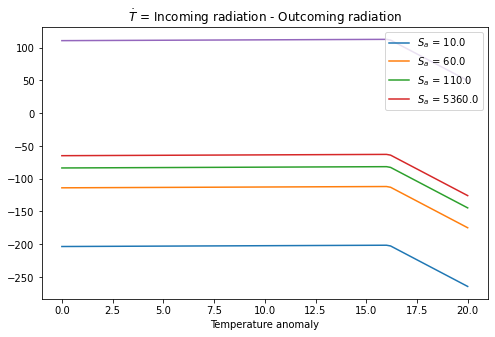

In [10]:
plt.title("$\\dot{T}$ = Incoming radiation - Outcoming radiation")
ri = Ri(To + T_mat[:, 0, :])
ro = Ro(To + T_mat[:, 0, :], F_mat[:,0, :])
plt.plot(T_grid, (ri - ro)[:, [0, 1,2,3, -1]])
plt.legend(["$S_a$ = {}".format(F) for F in F_grid[[0, 1, 2,-1]]])
plt.xlabel("Temperature anomaly")

In [11]:
T_grid[5], F_grid[17], C_grid[1]

(1.0, 860.0, 542.5)

In [12]:
(ri - ro)[6, 17]

19.200077070058796

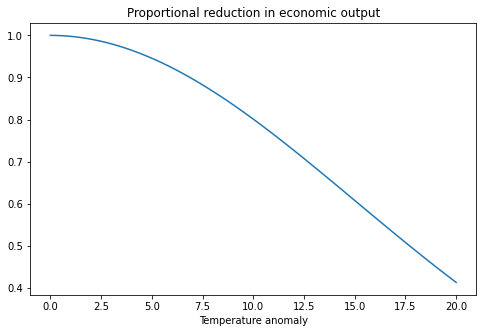

In [13]:
dG  = gamma_1 + gamma_2 * T_grid
G = gamma_1 * T_grid + gamma_2 / 2 * T_grid**2
plt.plot(T_grid, np.exp( -G) )
plt.xlabel("Temperature anomaly")
plt.title("Proportional reduction in economic output")
plt.show()

In [14]:
# Economic paramaters
gamma_1 = 1.7675 / 10000.
gamma_2 = 2 * 0.0022
delta   = 0.01
eta     = 0.032

# State variable
# Temperature anomaly, in celsius
T_min  = -10. 
T_max  = 20. # 
hT     = 1.5
T_grid = np.arange(T_min, T_max + hT, hT)

# atmospheric carbon concentration, in gigaton
C_min  = 532.5
C_max  = 1064
hC     = 40.
C_grid = np.arange(C_min, C_max + hC, hC)

# F, Sa in the notes, accumulative anthropogenic carbon, in gigaton
F_min = 10. # 10. avaoid 
F_max = 5325. # 2500 x2.13 gm # # on hold -> 4000 / 2.13 ppm
hF = 200.
F_grid = np.arange(F_min, F_max + hF, hF)

# meshgrid
(T_mat, C_mat, F_mat) = np.meshgrid(T_grid, C_grid, F_grid, indexing="ij")
stateSpace = np.hstack([
    T_mat.reshape(-1, 1, order="F"),
    C_mat.reshape(-1, 1, order="F"),
    F_mat.reshape(-1, 1, order="F")
])

T_mat.shape

(21, 15, 28)

In [28]:
# v0 =  - eta * T_mat - eta * F_mat

dG  = gamma_1 + gamma_2 * T_mat *(T_mat >= 0)

epsilon  = 4.
count    = 0
error    = 1.
tol      = 1e-8
max_iter = 1000
fraction = 1


while error > tol and count < max_iter:
    
    dvdT  = finiteDiff(v0, 0, 1, hT)
    dvdTT = finiteDiff(v0, 0, 2, hT)
    dvdC  = finiteDiff(v0, 1, 1, hC)
#     dvdC[dvdC >= - 1e-16] = - 1e-16
    dvdCC = finiteDiff(v0, 1, 2, hC)
    dvdF  = finiteDiff(v0, 2, 1, hF)
    dvdFF = finiteDiff(v0, 2, 2, hF)

        

    Ca = - eta * delta / (dvdC + dvdF)
    Ca[Ca <= 1e-32] = 1e-32
    
    if count >=1:
        Ca = Ca * fraction + Ca_star * (1 - fraction)
       
    A  = - delta * np.ones(T_mat.shape)
    B1 = Ri(T_mat + To) - Ro(T_mat + To, C_mat)
    B2 = Volcan
    B2 += Ca * sa
    B2 -= wa * C_mat * vegcover * veggrowth(T_mat +To)
    B2 += oceanatmphysflux(T_mat + To) * (1 - fracseaice(T_mat + To))
    B2 += oceanbioflux(T_mat + To, F_mat, sa) * (1 - fracseaice(T_mat + To))
    B2 += oceanatmcorrflux(C_mat) * (1 - fracseaice(T_mat + To))
    B3 = Ca
    C1 = 1e-4 * np.ones(T_mat.shape)
    C2 = 1e-4 * np.ones(T_mat.shape)
    C3 = np.zeros(T_mat.shape)
    D  = eta  * delta * np.log(Ca) + (eta - 1) * dG * B1

    out = PDESolver(stateSpace, A, B1, B2, B3, C1, C2, C3, D, v0, epsilon)
    v = out[2].reshape(v0.shape, order="F")

    rhs_error = A * v0 + B1 * dvdT + B2 * dvdC + B3 * dvdF + C1 * dvdTT + C2 * dvdCC + C3 * dvdFF + D
    rhs_error = np.max(abs(rhs_error))
    lhs_error = np.max(abs((v - v0)/epsilon))

    error = lhs_error
    v0 = v
    Ca_star = Ca
    count += 1

    print("Iteration %s: False Transient Error: %s; PDE Error %s" % (count, lhs_error, rhs_error))

print("Total iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))

Iteration 1: False Transient Error: 0.019765082962919275; PDE Error 0.19624099509768067
Iteration 2: False Transient Error: 0.039331890504196096; PDE Error 0.1936717802969692
Iteration 3: False Transient Error: 0.06433707671775707; PDE Error 0.16411289721591293
Iteration 4: False Transient Error: 0.047015553739869764; PDE Error 0.2657437970178287
Iteration 5: False Transient Error: 0.020411989891817528; PDE Error 0.1642031542928546
Iteration 6: False Transient Error: 0.017857901296556733; PDE Error 0.16817909932315978
Iteration 7: False Transient Error: 0.01783217833889992; PDE Error 0.16715647772908238
Iteration 8: False Transient Error: 0.01683979534970953; PDE Error 0.16312619056812228
Iteration 9: False Transient Error: 0.01855773305823591; PDE Error 0.326019578035595
Iteration 10: False Transient Error: 0.01676002168197241; PDE Error 0.5441238920456783
Iteration 11: False Transient Error: 0.017946548085593074; PDE Error 0.16230987706921418
Iteration 12: False Transient Error: 0.02

Iteration 95: False Transient Error: 0.014801835616113; PDE Error 0.1560304055874311
Iteration 96: False Transient Error: 0.018119952295317654; PDE Error 0.17914653622994098
Iteration 97: False Transient Error: 0.02008123319365843; PDE Error 0.7743805873771534
Iteration 98: False Transient Error: 0.017444014432487165; PDE Error 0.1715388338249939
Iteration 99: False Transient Error: 0.015224912563518093; PDE Error 0.27773610592630593
Iteration 100: False Transient Error: 0.016937523827077902; PDE Error 0.1619690962532534
Iteration 101: False Transient Error: 0.06206331294863184; PDE Error 0.568015989123646
Iteration 102: False Transient Error: 0.05009702672830462; PDE Error 0.2372208193073584
Iteration 103: False Transient Error: 0.015268810529737033; PDE Error 0.17927788297057745
Iteration 104: False Transient Error: 0.016573110649412366; PDE Error 0.2269831186396177
Iteration 105: False Transient Error: 0.016019333609783096; PDE Error 0.16607801958087798
Iteration 106: False Transien

Iteration 188: False Transient Error: 0.028301820297092866; PDE Error 0.25536008422628487
Iteration 189: False Transient Error: 0.02547476379054346; PDE Error 0.25401908516653426
Iteration 190: False Transient Error: 0.18729145120886734; PDE Error 0.17923041356324498
Iteration 191: False Transient Error: 0.18600015396091205; PDE Error 7.353231215614831
Iteration 192: False Transient Error: 0.04264921471508884; PDE Error 0.18152365589604771
Iteration 193: False Transient Error: 0.13600924710110754; PDE Error 0.1935180074738576
Iteration 194: False Transient Error: 0.13346656768385395; PDE Error 0.9914324531954343
Iteration 195: False Transient Error: 0.03385035175664791; PDE Error 0.19201924415881555
Iteration 196: False Transient Error: 0.031566780875420586; PDE Error 0.16075612435769315
Iteration 197: False Transient Error: 0.022197536439604315; PDE Error 0.8784763381178343
Iteration 198: False Transient Error: 0.017853579157366975; PDE Error 1.8524464968591188
Iteration 199: False Tr

Iteration 281: False Transient Error: 0.01508542981110296; PDE Error 0.15242157924393362
Iteration 282: False Transient Error: 0.02234331997164621; PDE Error 0.16308158057054634
Iteration 283: False Transient Error: 0.04478375963115924; PDE Error 0.16701436736552866
Iteration 284: False Transient Error: 0.04105862653000511; PDE Error 0.36352194916091496
Iteration 285: False Transient Error: 0.022739066978376105; PDE Error 0.16216961193362467
Iteration 286: False Transient Error: 0.015371391311370261; PDE Error 0.1761525568710347
Iteration 287: False Transient Error: 0.017929414491736434; PDE Error 0.24784363928580788
Iteration 288: False Transient Error: 0.01807498445411662; PDE Error 0.1530641206315977
Iteration 289: False Transient Error: 0.01801314309710473; PDE Error 0.16554285814043013
Iteration 290: False Transient Error: 0.019697553745312284; PDE Error 0.2829014567311079
Iteration 291: False Transient Error: 0.016110171798038905; PDE Error 0.17523441453816235
Iteration 292: Fals

Iteration 374: False Transient Error: 0.021152843484201475; PDE Error 0.17183219689166185
Iteration 375: False Transient Error: 0.01933085622350285; PDE Error 0.1503625352650393
Iteration 376: False Transient Error: 0.018346814851511656; PDE Error 0.16858864989951616
Iteration 377: False Transient Error: 0.020066224973050995; PDE Error 0.21838013158078207
Iteration 378: False Transient Error: 0.025305919726802316; PDE Error 0.21137520341960947
Iteration 379: False Transient Error: 0.021781901419147653; PDE Error 0.4653921489333172
Iteration 380: False Transient Error: 0.022950293006819555; PDE Error 0.2009984529885266
Iteration 381: False Transient Error: 0.01912432606727718; PDE Error 0.1668782480408657
Iteration 382: False Transient Error: 0.015090718731581174; PDE Error 0.5734801850566034
Iteration 383: False Transient Error: 0.01995437949117667; PDE Error 0.15284078041257265
Iteration 384: False Transient Error: 0.020329088434926694; PDE Error 0.338483511576511
Iteration 385: False

Iteration 467: False Transient Error: 0.018100871037080423; PDE Error 0.21238958067159142
Iteration 468: False Transient Error: 0.031160279472649766; PDE Error 0.15566777367474094
Iteration 469: False Transient Error: 0.033028521259924004; PDE Error 0.20624445372534964
Iteration 470: False Transient Error: 0.018137203158788445; PDE Error 0.1820456620410238
Iteration 471: False Transient Error: 0.01640334262869369; PDE Error 0.17118489747632815
Iteration 472: False Transient Error: 0.016712197939742976; PDE Error 0.2562153319494387
Iteration 473: False Transient Error: 0.01999604314017908; PDE Error 0.25593380101835717
Iteration 474: False Transient Error: 0.019614636108735664; PDE Error 0.2487231008238478
Iteration 475: False Transient Error: 0.0163092305623086; PDE Error 0.17123825599213927
Iteration 476: False Transient Error: 0.017717285981378783; PDE Error 0.16563971888274542
Iteration 477: False Transient Error: 0.018088109964879598; PDE Error 0.16095811269166882
Iteration 478: Fa

Iteration 560: False Transient Error: 0.7053761989053503; PDE Error 23.71279739690801
Iteration 561: False Transient Error: 0.03932898078361622; PDE Error 0.7111772235428988
Iteration 562: False Transient Error: 0.018708349621368137; PDE Error 0.16115630933939284
Iteration 563: False Transient Error: 0.04523826113946353; PDE Error 0.1659648458384031
Iteration 564: False Transient Error: 0.04569646707836834; PDE Error 4.6674532568054765
Iteration 565: False Transient Error: 0.018622807456187718; PDE Error 0.16810935453906994
Iteration 566: False Transient Error: 0.017492519358101234; PDE Error 0.2753842032759742
Iteration 567: False Transient Error: 0.01984972662139804; PDE Error 0.16227782177443562
Iteration 568: False Transient Error: 0.017006035754149523; PDE Error 0.16422799987540726
Iteration 569: False Transient Error: 0.018638012326563855; PDE Error 0.15723989799624905
Iteration 570: False Transient Error: 0.018179655877494778; PDE Error 0.20269553578698396
Iteration 571: False T

Iteration 652: False Transient Error: 0.12567277958659928; PDE Error 0.8661601285841707
Iteration 653: False Transient Error: 0.03271552387024512; PDE Error 0.2717647574722859
Iteration 654: False Transient Error: 0.018610969169784136; PDE Error 0.1666321359796581
Iteration 655: False Transient Error: 0.018403192753163017; PDE Error 0.3602709663839496
Iteration 656: False Transient Error: 0.029100187183148857; PDE Error 0.26753427793837936
Iteration 657: False Transient Error: 0.026596292288880635; PDE Error 0.4734760934372648
Iteration 658: False Transient Error: 0.02162154954661298; PDE Error 0.16875460309853318
Iteration 659: False Transient Error: 0.016308151632226393; PDE Error 0.379950408525761
Iteration 660: False Transient Error: 0.02974318974468252; PDE Error 0.2890878033482527
Iteration 661: False Transient Error: 0.018117254470376237; PDE Error 0.2533992495552594
Iteration 662: False Transient Error: 0.01562954294783404; PDE Error 0.18009063098655576
Iteration 663: False Tra

Iteration 745: False Transient Error: 0.07841809208196862; PDE Error 1.1265323641542488
Iteration 746: False Transient Error: 0.018787120058813528; PDE Error 0.4465557666866655
Iteration 747: False Transient Error: 0.019731040018056034; PDE Error 0.16404783192842337
Iteration 748: False Transient Error: 0.018978469931303296; PDE Error 0.17442012754719172
Iteration 749: False Transient Error: 0.032617427775355576; PDE Error 0.28791341086956357
Iteration 750: False Transient Error: 0.028599476955612366; PDE Error 0.1862558513653345
Iteration 751: False Transient Error: 0.0293334518468643; PDE Error 0.2626888261804676
Iteration 752: False Transient Error: 0.021689510239032816; PDE Error 0.1639785890313048
Iteration 753: False Transient Error: 0.01833863643329471; PDE Error 0.1556956695124092
Iteration 754: False Transient Error: 0.01867329213844295; PDE Error 0.22223670446771257
Iteration 755: False Transient Error: 0.02250146989800415; PDE Error 0.28845480701595383
Iteration 756: False T

Iteration 838: False Transient Error: 0.14148541170398718; PDE Error 0.5343900941994566
Iteration 839: False Transient Error: 0.03063646318429683; PDE Error 0.1673071538296389
Iteration 840: False Transient Error: 0.017511206973729484; PDE Error 0.38661998910543627
Iteration 841: False Transient Error: 0.01880790384620465; PDE Error 0.19311178837848875
Iteration 842: False Transient Error: 0.021232961165334602; PDE Error 0.1688256132844823
Iteration 843: False Transient Error: 0.02437692245741429; PDE Error 0.1683834659660599
Iteration 844: False Transient Error: 0.02371219436699923; PDE Error 0.7538760421755746
Iteration 845: False Transient Error: 0.029741525963423596; PDE Error 0.6306976850929564
Iteration 846: False Transient Error: 0.021905273929758336; PDE Error 0.1879700301096956
Iteration 847: False Transient Error: 0.02361486151282059; PDE Error 0.5186065923762694
Iteration 848: False Transient Error: 0.01824483655788968; PDE Error 0.3121271239091544
Iteration 849: False Trans

Iteration 931: False Transient Error: 0.01722347756714676; PDE Error 0.32446802583549417
Iteration 932: False Transient Error: 0.01963740720143456; PDE Error 0.1621257666658651
Iteration 933: False Transient Error: 0.09916963736645207; PDE Error 0.2742123680248638
Iteration 934: False Transient Error: 0.08546331577081126; PDE Error 4.457473138837674
Iteration 935: False Transient Error: 0.02438060781589785; PDE Error 0.1642141526480141
Iteration 936: False Transient Error: 0.017579072240333532; PDE Error 0.23067391756755107
Iteration 937: False Transient Error: 0.017484026736387423; PDE Error 0.16650246213086994
Iteration 938: False Transient Error: 0.01803882250723368; PDE Error 0.19264801895397587
Iteration 939: False Transient Error: 0.08812551443534287; PDE Error 0.22201343770065177
Iteration 940: False Transient Error: 0.08593214584865075; PDE Error 0.3616140135460739
Iteration 941: False Transient Error: 0.02358874929799676; PDE Error 0.17233041591922094
Iteration 942: False Tran

In [30]:
B1.max(), B1.min(), v0.min(), v0.mean(), v0.max(), Ca.min(), Ca.max(), v0.mean()

(32.92500734401847,
 -65.86220037528938,
 -0.5201307254590409,
 0.024829358275450162,
 0.9220188052736584,
 1e-32,
 1227.1038730710432,
 0.024829358275450162)

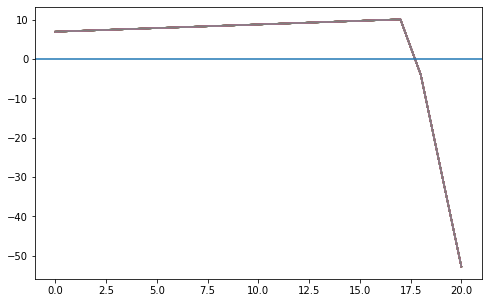

In [31]:
plt.plot(B1[:, 4, :])
plt.axhline(0)
plt.show()

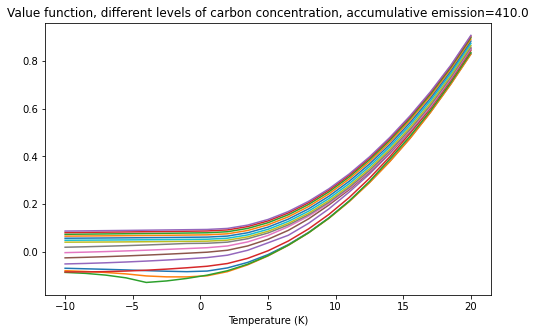

In [32]:
ii = 2
plt.plot(T_grid, v0[:, :, ii])
plt.xlabel("Temperature (K)")
plt.title("Value function, different levels of carbon concentration, accumulative emission={}".format(F_grid[ii]))
plt.show()

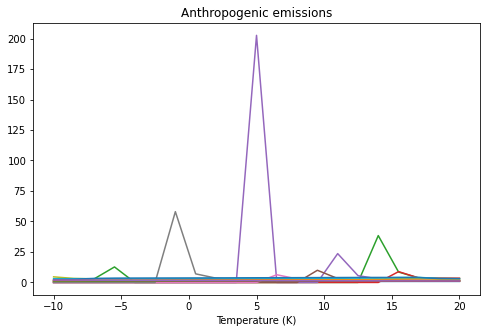

In [33]:
plt.plot(T_grid, Ca[:, :, ii])
plt.xlabel("Temperature (K)")
plt.title("Anthropogenic emissions")
plt.show()

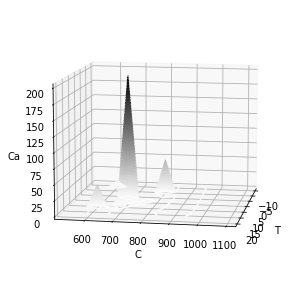

In [34]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(T_mat[:, :, 10], C_mat[:, :, 10], Ca[:, :, ii], 90, cmap='binary')
ax.set_xlabel('T')
ax.set_ylabel('C')
ax.set_zlabel('Ca')
ax.view_init(10, 10)

In [35]:
t_max = 100.
dt = 1/12
gridpoints = (T_grid, C_grid, F_grid)   
Ca_func = RegularGridInterpolator(gridpoints, Ca)

T_0 = 9.72 + 1.1
C_0 = 587.40
F_0 = 870

def get_e(x):
    return Ca_func([x[0] - To, x[1], x[2]])

# Ocean albedo
def alphaocean_1d(T):
    if T < Talphaocean_low:
        return alphaocean_max
    elif T < Talphaocean_high:
        return alphaocean_max + (alphaocean_min - alphaocean_max) / (Talphaocean_high - Talphaocean_low) * (T - Talphaocean_low)
    else: # so T is higher
        return alphaocean_min

# Vegetation growth function
def veggrowth_1d(T):
    if T < Tlow:
        return 0
    if (T >= Tlow) and (T < Topt1):
        return acc / (Topt1 - Tlow) * (T - Tlow)
    if (T >= Topt1) and (T <= Topt2):
        return acc
    if (T > Topt2) and (T < Thigh):
        #return acc
        return acc / (Topt2 - Thigh) * (T - Thigh)
    if T > Thigh:
        #return acc
        return 0

def oceanatmphysflux_1d(T):
    return 1 / tauc * (coc0 * (np.exp(-bP * (T - T0))))

def fracseaice_1d(T):
    if T < Talphaocean_low:
        return 1
    elif T < Talphaocean_high:
        return 1 - 1 / (Talphaocean_high - Talphaocean_low) * (T - Talphaocean_low)
    else: # so T is higher
        return 0

def biopump_1d(Cc):
    if Cc < Cbio_low:
        return 1
    elif Cc < Cbio_high:
        return 1 - 1 / (Cbio_high - Cbio_low) * (Cc - Cbio_low)
    else: 
        return 0


def oceanbioflux_1d(T, F, sa):
     return 1/tauc * (coc0 * (np.exp(bB * biopump_1d(F) * (T - T0))))

def oceanatmcorrflux_1d(C):
    return 1 / tauc * (- cod * C)


def mu_T(x):
    Ri_t = 1 / cearth * (Q0 * (1 - p * alphaland - (1 - p) * alphaocean(x[0])))
    Ro_t = 1 / cearth * (kappa * (x[0] - Tkappa) -  B * np.log(x[1] / C0))
    return Ri_t - Ro_t

def mu_C(x):
    Ca_t = Ca_func([x[0] - To, x[1], x[2]])
    dC = Volcan
    dC += Ca_t * sa
    dC -= wa * x[1] * vegcover * veggrowth_1d(x[0])
    dC += oceanatmphysflux_1d(x[0]) * (1 - fracseaice_1d(x[0]))
    dC += oceanbioflux_1d(x[0], x[2], sa) * (1 - fracseaice_1d(x[0]))
    dC += oceanatmcorrflux_1d(x[1]) * (1 - fracseaice_1d(x[0]))
    return dC

def mu_Sa(x):
    return Ca_func([x[0] - To, x[1], x[2]])

years  = np.arange(0, t_max + dt, dt)
pers   = len(years)

hist      = np.zeros([pers, 3])
e_hist    = np.zeros([pers])


for tm in range(pers):
    if tm == 0:
        # initial points
        hist[0,:] = [T_0, C_0, F_0] # logL
        e_hist[0] = get_e(hist[0, :])

    else:
        # other periods
        e_hist[tm] = get_e(hist[tm-1,:])

        hist[tm,0] = hist[tm-1,0] + mu_T(hist[tm-1,:]) * dt
        hist[tm,1] = hist[tm-1,1] + mu_C(hist[tm-1,:]) * dt
        hist[tm,2] = hist[tm-1,2] + mu_Sa(hist[tm-1,:]) * dt


Text(0.5, 0, 'Years')

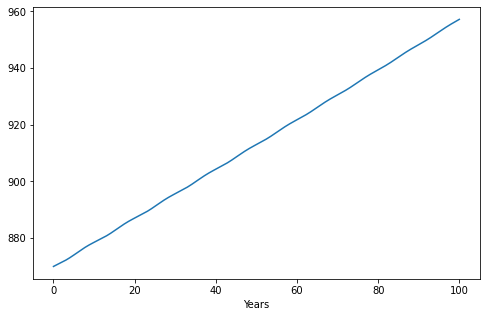

In [36]:
plt.plot(years, hist[:, 2])
plt.xlabel("Years")

Text(0.5, 1.0, 'Emission')

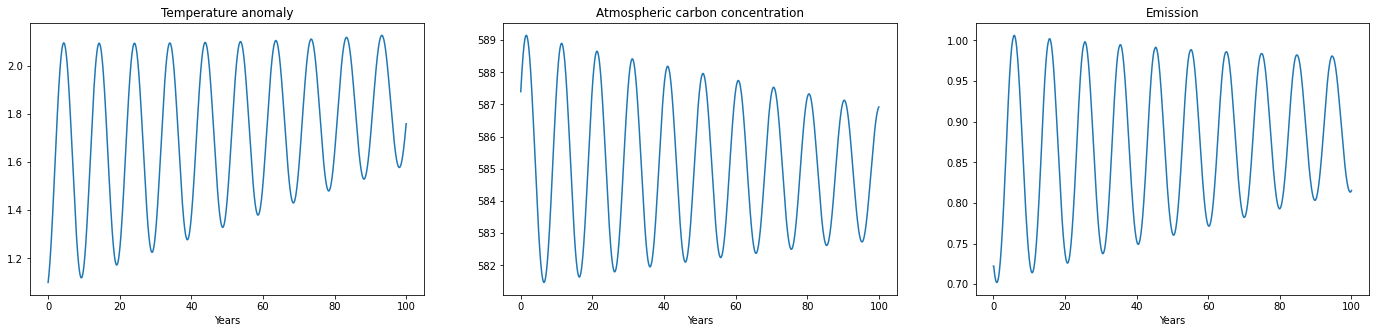

In [37]:
plt.subplots(1,3, figsize=(24,5))
plt.subplot(131)
plt.plot(years, hist[:, 0] - To)
plt.xlabel("Years")
plt.title("Temperature anomaly")
plt.subplot(132)
plt.plot(years, hist[:, 1])
plt.xlabel("Years")
plt.title("Atmospheric carbon concentration")
plt.subplot(133)
plt.plot(years, e_hist)
plt.xlabel("Years")
plt.title("Emission")